# USING RANDOM FORESTS

# Imports and Data

In [1]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from IPython.display import display
from sklearn.tree import export_graphviz
from scipy.stats import binom
import matplotlib.pyplot as plt
from sklearn import tree

from common.trinary_data import TrinaryData
from common_python.classifier.feature_set import FeatureSet

In [2]:
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False, is_regulator=True)  # Trinary data
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y

In [3]:
SER_Y1 = SER_Y.apply(lambda v: 1 if v==1 else 0)
SER_Y1

T1.0     0
T1.1     0
T1.2     0
T2.0     1
T2.1     1
        ..
T24.1    0
T24.2    0
T25.0    0
T25.1    0
T25.2    0
Name: name, Length: 75, dtype: int64

Note some transformation is required if this is a binary classifier.

# Random Forest Usage

1. The RandomForest classifier creates decision trees that can be obtained from the property ``estimators_``.
1. The relative weighting of features can be found in ``feature_importances_``.
1. An estimator is a DecisionTree. This has the properties:
   1. ``tree_.value``: class splits at that node
   1. ``myTree.tree_.threshold`` is an array of thresholds for spitting values for "<=", such as Rv3911 <= -0.5.
   out-of-range thresholds indicate leaves.

In [4]:
# Bootstrap == False: use all of the samples
clf = RandomForestClassifier(max_depth=4, random_state=0, bootstrap=False,
                            min_impurity_decrease=.01, min_samples_leaf=5)
_ = clf.fit(DF_X, SER_Y1)

# Visualization

In [5]:
binom.cdf(4, 5, 0.5)

0.96875

In [7]:
myTree = clf.estimators_[0]

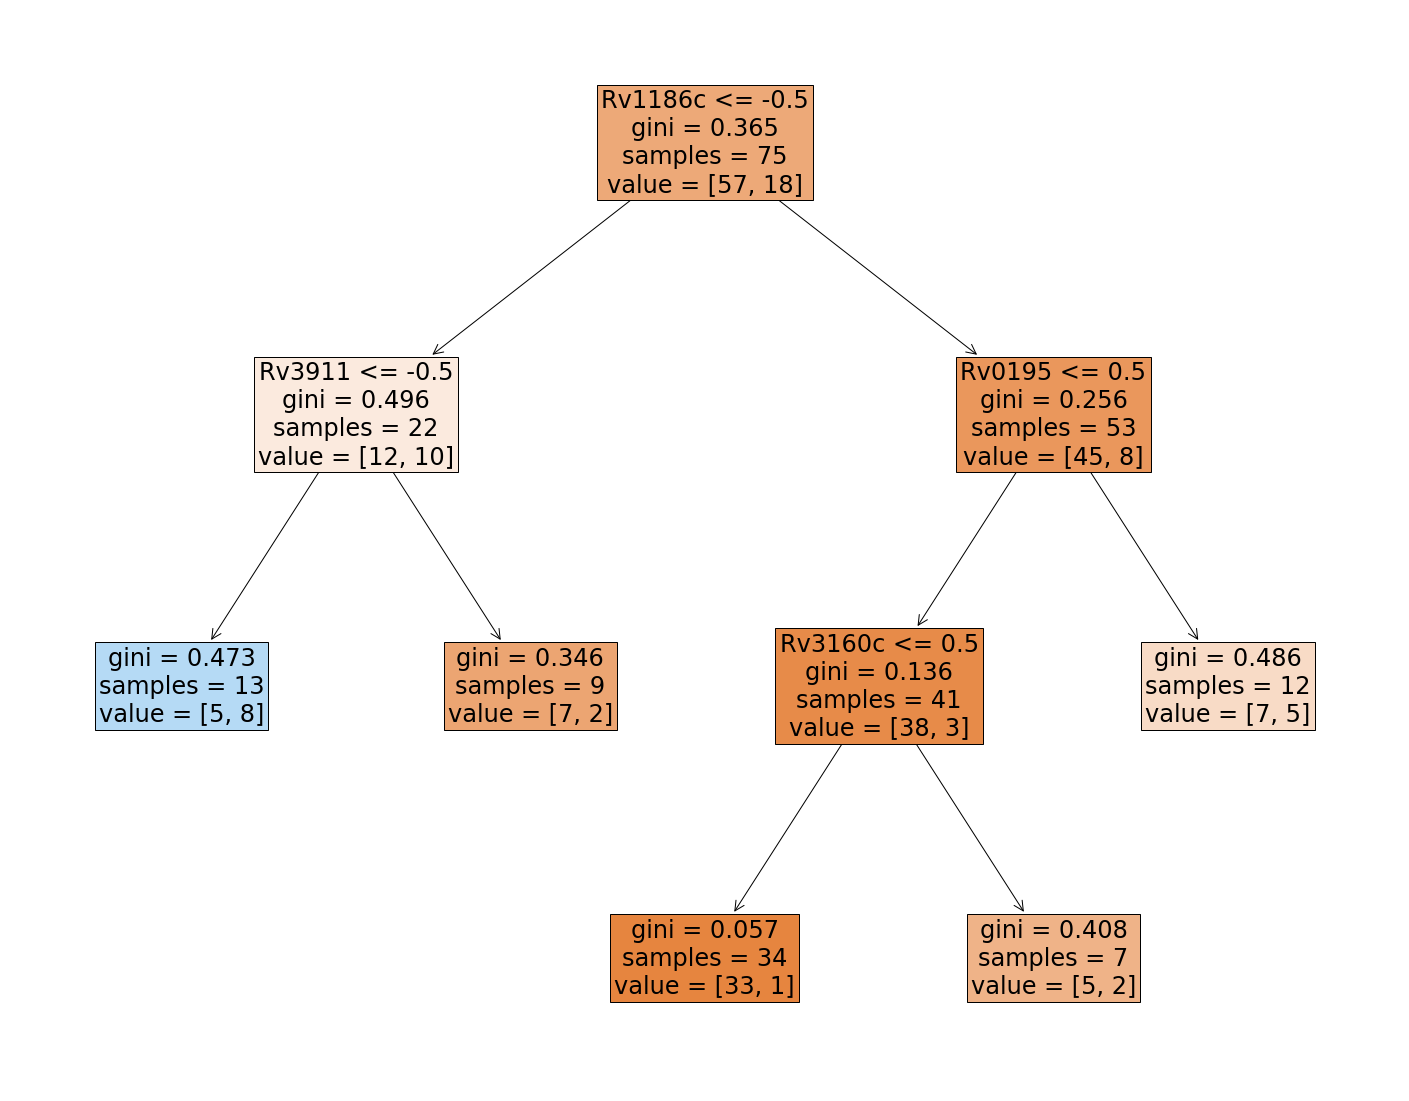

In [9]:
# Creates plots in matplotlib
fig = plt.figure(figsize=(25,20))
# the clf is Decision Tree object
_ = tree.plot_tree(myTree,feature_names=DF_X.columns, fontsize=24,
                   filled=True)


In [10]:
myTree.tree_.children_left

array([ 1,  2, -1, -1,  5,  6, -1, -1, -1])

In [11]:
myTree.tree_.threshold

array([-0.5, -0.5, -2. , -2. ,  0.5,  0.5, -2. , -2. , -2. ])

In [12]:
# The feature property provides maps from the node index in the tree (position in the array)
# to the node index in the original set of features
myTree.tree_.feature

array([27, 45, -2, -2, 52, 85, -2, -2, -2])

In [13]:
# Position zero has a 45, which is the node index in the original features
list(DF_X.columns)[45]

'Rv3911'

Notes
1. Can find the nodes used via decision path. Will that give me node values?
1. Can find number of samples in a leaf. Use impurity to get split between classes?

In [14]:
myTree.tree_.value

array([[[57., 18.]],

       [[12., 10.]],

       [[ 5.,  8.]],

       [[ 7.,  2.]],

       [[45.,  8.]],

       [[38.,  3.]],

       [[33.,  1.]],

       [[ 5.,  2.]],

       [[ 7.,  5.]]])

# Programming Notes

## Decision Rules

In [15]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    
tree_to_code(myTree, DF_X.columns)

def tree(Rv2642, Rv0022c, Rv1675c, Rv3167c, Rv1189, Rv2488c, Rv1395, Rv0324, Rv3082c, Rv1049, Rv1460, Rv1674c, Rv0767c, Rv3249c, Rv2034, Rv0081, Rv0232, Rv0117, Rv3855, Rv0047c, Rv0067c, Rv2359, Rv1990c, Rv0474, Rv2250c, Rv0330c, Rv3830c, Rv1186c, Rv2506, Rv3066, Rv0623, Rv1773c, Rv0078, Rv0494, Rv1719, Rv3164c, Rv2011c, Rv0602c, Rv2760c, Rv1657, Rv1473A, Rv3183, Rv3833, Rv3405c, Rv2827c, Rv3911, Rv2017, Rv0674, Rv1556, Rv3124, Rv3862c, Rv0880, Rv0195, Rv2009, Rv0827c, Rv0894, Rv0302, Rv0653c, Rv3219, Rv0135c, Rv3416, Rv1219c, Rv1176c, Rv2021c, Rv0967, Rv3095, Rv0158, Rv2779c, Rv0023, Rv0042c, Rv3173c, Rv1846c, Rv2069, Rv0238, Rv3050c, Rv3223c, Rv1404, Rv0445c, Rv1332--Rv1828--Rv0981, Rv1379, Rv3676, Rv2595, Rv1423, Rv1956, Rv3291c, Rv3160c, Rv3849, Rv3557c, Rv2745c, Rv3414c, Rv1359, Rv0891c, Rv3597c, Rv3133c, Rv0353, Rv0054, Rv1994c, Rv3417c, Rv3246c, Rv3260c):
  if Rv1186c <= -0.5:
    if Rv3911 <= -0.5:
      return [[5. 8.]]
    else:  # if Rv3911 > -0.5
      return [[7. 2.]]
  el

## Finding Leaves

In [17]:
if False:
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

## Feature Values

Feature values are taken from the numpy array supplied to the decision tree.
Columns are features; rows are samples (instances).

# Decision Tree Extractor
Extracts key information from a fitted decision tree:
* Cases (feature set + feature vector)

In [18]:
features = ["Rv3911", "Rv3405c"]
fs = FeatureSet(features)
fs.__dict__

{'intercept': None,
 'coefs': None,
 'set': {'Rv3405c', 'Rv3911'},
 'str': 'Rv3405c+Rv3911',
 '_analyzer': None,
 'list': ['Rv3405c', 'Rv3911']}

In [19]:
fs.profileTrinary(trinary=TRINARY)

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [ ]:
class Case(object):
    
    def __init__(self, feature_set, feature_values, siglvl):
        self.feature_set = feature_set
        self.feature_values = feature_values
        self.siglvl = siglvl
    
    @classmethod
    def calcSiglvl(cls, features, trinary):
        feature_set = FeatureSet(features)
        df_profile = self.feature_set.profileTrinary(trinary=trinary)
        for idx, row in df_profile.iterrow():
        